In [1]:
import numpy as np
import os

import torch
from torch.autograd import Variable
import torch.nn.functional as F
v
import uproot

import matplotlib.pyplot as plt
%matplotlib inline
#import imageio

from scipy.stats import ks_2samp
from scipy.special import erfinv

from sklearn.preprocessing import RobustScaler

torch.manual_seed(1)    # reproducible
np.random.seed(1)

os.chdir('../src')
from regression_analysis import guassian_comparison_ratio, correct_compare_hist

In [2]:
def  get_input_arrays(tree, features_list):
    array = np.transpose(tree.arrays(features_list, outputtype=tuple))
    print(array.shape)
    print(array[0])
    return array

def plot_dnn_features(arrays, features_list, nBins=25):   
    
    arrays_shape = arrays.shape
    print(arrays_shape)
    arrays = np.transpose(arrays)
    
    fig, ax = plt.subplots(int(arrays_shape[1]),3, figsize=(15, 9))
    print(arrays_shape[1])
    
    feature_n = 0
    
    for j in range(int(arrays_shape[1]/2.)):            
            
        for k in range(3):
            
            if feature_n <= arrays_shape[1] - 1:
                
                ax[j,k].hist(arrays[feature_n], bins=nBins)
                ax[j,k].set_title(features_list[feature_n])
                feature_n += 1
            else:
                break

In [3]:
os.chdir('../data')

In [4]:
tree = uproot.open('TARJetImages_hh4W_kt0_5delta0_5_noSD_2019041.root')['tree']
tree.keys()

[b'weight',
 b'eventNumber',
 b'jet_pt',
 b'jet_eta',
 b'jet_phi',
 b'jet_m',
 b'c2',
 b'c3',
 b'c4',
 b'd2',
 b'd3',
 b'm2',
 b'm3',
 b'n2',
 b'n3',
 b'tau21',
 b'tau32',
 b'tau43',
 b'tau42',
 b'tau21_wta',
 b'tau32_wta',
 b'tau43_wta',
 b'tau42_wta',
 b'image',
 b'node_kt',
 b'node_delta',
 b'node_kt_primary',
 b'node_delta_primary',
 b'lund_plane',
 b'lund_plane_primary',
 b'subjets_pt',
 b'subjets_eta',
 b'subjets_phi',
 b'tracks_pt',
 b'tracks_eta',
 b'tracks_phi']

In [5]:
features_list = [b'jet_pt',b'jet_eta',b'jet_phi']

In [6]:
features_array = get_input_arrays(tree, features_list)

(909523, 3)
[4.5773434e+05 3.8268149e-02 8.9606994e-01]


In [7]:
np.where(np.isnan(features_array) == True)

(array([], dtype=int64), array([], dtype=int64))

In [8]:
#plot_dnn_features(features_array, features_list)

In [9]:
transformer = RobustScaler()
features_array_scaled = transformer.fit_transform(features_array)
print(features_array_scaled.shape)

(909523, 3)


In [10]:
mass_target = tree.array(b'jet_m')
mass_transformer = RobustScaler()
mass_target_scaled = mass_transformer.fit_transform(mass_target.reshape(-1,1))
print(mass_target_scaled.shape)

(909523, 1)


In [11]:
# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_first, n_second, n_third, n_output):
        super(Net, self).__init__()
        self.first = torch.nn.Linear(n_feature, n_first)   # hidden layer
        self.second = torch.nn.Linear(n_first, n_second)   # output layer
        self.third = torch.nn.Linear(n_second, n_third)   # output layer
        self.predict = torch.nn.Linear(n_third, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.first(x))      # activation function for hidden layer
        x = F.relu(self.second(x))
        x = F.relu(self.third(x))
        x = self.predict(x)             # linear output
        return x

net = Net(n_feature=3, n_first=400, n_second=200, n_third=100, n_output=1)     # define the network
# print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss)

In [12]:
data_x_torch = Variable(torch.from_numpy(features_array_scaled.reshape(len(features_array_scaled),3)))
data_z_torch = Variable(torch.from_numpy(mass_target_scaled.reshape(len(features_array_scaled),1)))

In [13]:
net = net.float()

In [14]:
torch_dataset = Data.TensorDataset(data_x_torch[:10000].float(), data_z_torch[:10000].float())

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=32, 
    shuffle=True, num_workers=2,)

In [15]:
loss_values = []
EPOCHS = 200
# train the network
for epoch in range(EPOCHS):
    if (epoch%int(EPOCHS/10.) == 0): print(epoch)
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        prediction = net(b_x)     # input x and predict based on x

        loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
        #loss_values.append(loss.item())
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    #loss_values.append(loss_func(net(data_x_torch.float()), data_z_torch.float()).item())
    loss_values.append(loss_func(net(data_x_torch.float()), data_z_torch.float()).item())

0
20
40
60
80
100
120
140
160
180


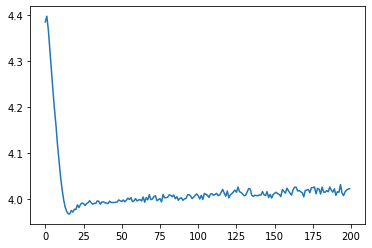

In [16]:
plt.plot(range(len(loss_values)),loss_values)
plt.show()

In [17]:
test_z_torch = net(data_x_torch[1000:2000].float())

In [18]:
#error = torch.sqrt(torch.mul(test_z_torch - torch.from_numpy(true_z).float(), test_z_torch - torch.from_numpy(true_z).float()))*100.

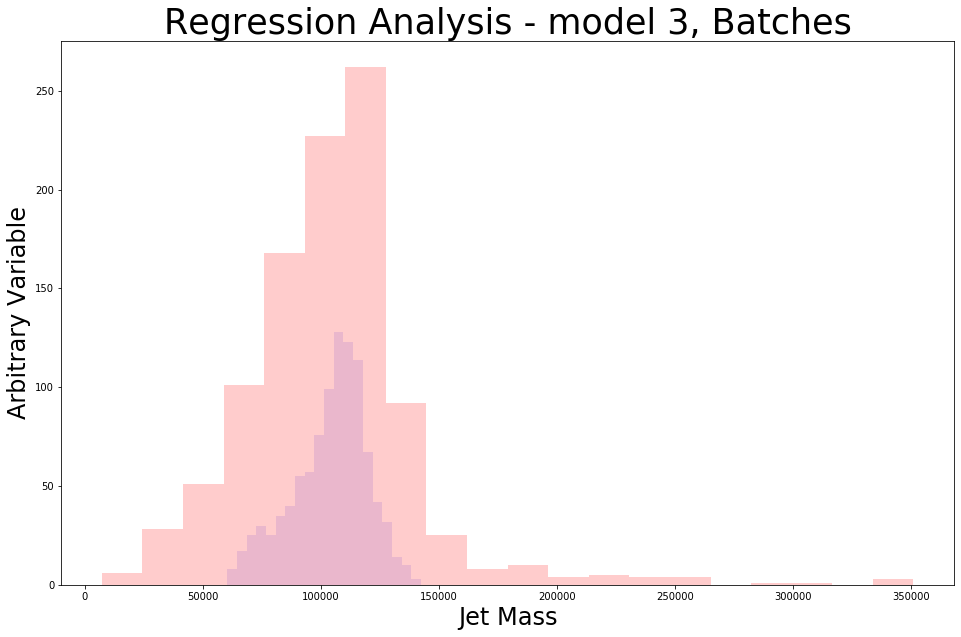

In [19]:
fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title('Regression Analysis - model 3, Batches', fontsize=35)
ax.set_xlabel('Jet Mass', fontsize=24)
ax.set_ylabel('Arbitrary Variable', fontsize=24)
#ax.set_xlim(-11.0, 13.0)
#ax.set_ylim(-1.1, 1.2)
ax.hist(mass_transformer.inverse_transform(test_z_torch.data.numpy()), color = "blue", alpha=0.1, bins=20)
#prediction = net(x)     # input x and predict based on x
ax.hist(mass_transformer.inverse_transform(data_z_torch[1000:2000].data.numpy()), color='red', alpha=0.2,bins=20)
#plt.savefig('curve_2_model_3_batches.png')
plt.show()


In [20]:
def guassian_comparison_ratio(data_sig, data_bkg, nBins=20):
    # data_norm = np.random.normal(size=100000)
    # data_sig = 1. - np.random.power(2,size=10000)
    # data_bkg = 1. - np.random.power(6,size=10000)

    # data_sig_std = data_sig
    # data_bkg_std = data_bkg

    # print(uproot.open('/Users/blakeforland/WORKING/SOURCE/dihiggs/data/TARJetImages_hh4W_kt0_5delta0_5_noSD_2019041.root')['tree'].keys())
    # data_sig = uproot.open('/Users/blakeforland/WORKING/SOURCE/dihiggs/data/TARJetImages_hh4W_kt0_5delta0_5_noSD_2019041.root')['tree'].array('jet_pt')
    # data_sig = data_sig[np.logical_not(np.isnan(data_sig))]
    # data_bkg = uproot.open('/Users/blakeforland/WORKING/SOURCE/dihiggs/data/TARJetImages_JZXW_kt0_5delta0_5_noSD_2019041.root')['tree'].array('jet_pt')
    # data_bkg = data_bkg[np.logical_not(np.isnan(data_bkg))]
    data_norm = np.random.normal(size=len(data_bkg))

    data_sig_std = (
        2 * (data_sig - np.min(data_sig)) / (np.max(data_sig) - np.min(data_sig)) - 1
    )
    data_bkg_std = (
        2 * (data_bkg - np.min(data_bkg)) / (np.max(data_bkg) - np.min(data_bkg)) - 1
    )
    data_norm_std = (
        2 * (data_norm - np.min(data_norm)) / (np.max(data_norm) - np.min(data_norm))
        - 1
    )

    # data_sig_std = (data_sig - np.mean(data_sig))/np.std(data_sig)
    # data_bkg_std = (data_bkg - np.mean(data_bkg))/np.std(data_bkg)
    # data_norm_std = (data_norm - np.mean(data_norm))/np.std(data_norm)

    sig_hist, sig_bins, _ = plt.hist(
        data_sig_std, bins=nBins, alpha=0.5, color="red", density=True
    )
    bkg_hist, bkg_bins, _ = plt.hist(
        data_bkg_std, bins=nBins, alpha=0.5, color="blue", density=True
    )
    # plt.hist(data_norm_std,bins=100,alpha=.5,color='green',normed=True)

    # print(sig_hist)
    # print(sig_bins)
    # plt.savefig('dist.png')
    plt.close()

    std_sig_hist, std_sig_bins, _ = plt.hist(
        data_sig_std, bins=nBins, alpha=0.5, color="red", density=True, cumulative=True
    )
    std_bkg_hist, std_bkg_bins, _ = plt.hist(
        data_bkg_std, bins=nBins, alpha=0.5, color="blue", density=True, cumulative=True
    )
    norm_hist, norm_bins, _ = plt.hist(
        data_norm_std,
        bins=nBins,
        alpha=0.5,
        color="green",
        density=True,
        cumulative=True,
    )
    # print(std_bkg_hist)
    # print(norm_hist)
    # print(norm_hist-std_bkg_hist)
    # plt.savefig('std_dist.png')
    plt.close()
    ratio = norm_hist / std_bkg_hist
    '''
    #print(ratio)
    #bkg_hist = bkg_hist/len(data_bkg)
    #prototype = [] 
    #for bin,SF in zip(bkg_hist,ratio):
    #    prototype.append( bin*SF)

    #plt.plot(prototype)
    #plt.savefig('prototype.png')
    #plt.close()
    #bkg_gauss_norm=erfinv(std_bkg_bins)
    #print(len(norm_hist))
    #plt.scatter(range(len(ratio)),ratio)
    #plt.savefig('scatter.png')
    #plt.close()
    
    #for i in range(nBins):
    #    bkg_bins = (std_bkg_bins[i+1] - std_bkg_bins[i])/2
    #    sig_bins = (std_sig_bins[i+1] - std_sig_bins[i])/2

    bkg_data_indeces=np.digitize(data_bkg_std, std_bkg_bins[:nBins]) -1 
    sig_data_indeces=np.digitize(data_sig_std, std_sig_bins[:nBins]) -1 

    #final=np.ones(len(bkg_data_indeces))

    weights_bkg = []
    weights_sig = []
    values = []
    #for i in range(len(std_bkg_hist)):
    #    final[np.where(bkg_data_indeces == i)[0]] = ratio[i]
    #print(len(ratio))
    for i in range(len(bkg_data_indeces)):
        weights_bkg.append(ratio[bkg_data_indeces[i]])
        values.append(ratio[bkg_data_indeces[i]]*data_bkg_std[i])
    for i in range(len(sig_data_indeces)):
        weights_sig.append(ratio[sig_data_indeces[i]])

    #print(np.mean(values), np.std(values), np.min(values), np.max(values))

    #print(len(np.where(final=0)[0]))

    #gauss_bkg = np.multiply(data_bkg_std, final)

    #data_sig_std = 2 * (data_sig_std - np.min(data_sig_std))/(np.max(data_sig_std) - np.min(data_sig_std)) - 1
    #data_bkg_std = 2 * (data_bkg_std - np.min(data_bkg_std))/(np.max(data_bkg_std) - np.min(data_bkg_std)) - 1
    
    print(data_bkg_std[:5])
    print(weights_bkg[:5])
    weighted_bkg = np.multiply(data_bkg_std, weights_bkg)
    weighted_sig = np.multiply(data_sig_std, weights_sig)
    final_bkg_stat = np.std(weighted_bkg)/np.mean(weighted_bkg)
    final_sig_stat = np.std(weighted_sig)/np.mean(weighted_sig)
    print(final_bkg_stat)
    print(final_sig_stat)
    print("Error of "+str(np.round(np.sqrt(np.power(final_bkg_stat - final_sig_stat, 2)) * 100, 2))+"%")
    print(np.shape(np.asarray(weights_bkg).reshape(1000)))
    fig, ax = plt.subplots(figsize=(16,10))
    h1,b1,_=ax.hist(data_bkg_std,bins=nBins,density=True,weights=np.asarray(weights_bkg).reshape(1000),alpha=.2,color='blue')
    h2,b2,_=ax.hist(data_sig_std,bins=nBins,density=True,weights=np.asarray(weights_sig).reshape(1000),alpha=.2,color='red')
    #print(np.sqrt(np.power(h1 - h2, 2)))
    print(h1/np.max(h1))
    print(h2/np.max(h2))
    ax.hist(data_bkg_std,bins=nBins,density=True,weights=np.asarray(weights_bkg).reshape(1000),alpha=1.,color='blue', histtype='step', linewidth=2.0)
    ax.hist(data_sig_std,bins=nBins,density=True,weights=np.asarray(weights_sig).reshape(1000),alpha=1.,color='red', histtype='step', linewidth=2.0)
    plt.title('Regression Analysis', fontsize=24)
    plt.xlabel('Regression Value', fontsize=24)
    plt.ylabel('Arbitrary Unit', fontsize=24)

    plt.savefig('guass_dist.png')
    '''
    return ratio

In [21]:
ratio = guassian_comparison_ratio(mass_transformer.inverse_transform(test_z_torch.data.numpy()), mass_transformer.inverse_transform(data_z_torch[1000:2000].data.numpy()))

In [22]:
def correct_compare_hist(true_z, test_z_torch, ratio=None):
    hist1, bins1, _ = plt.hist(
        true_z, color="blue", alpha=0.2, bins=20
    )  # , weights=true_z_w)
    plt.close()

    bins2 = bins1
    hist2 = np.zeros(len(hist1))

    # z_reg = np.multiply(test_z_torch.data.numpy().reshape(1000), test_z_w)
    #z_reg = test_z_torch.data.numpy().reshape(len(true_z))
    z_reg = test_z_torch

    for i in range(len(hist1)):
        hist2[i] = len(
            np.where(z_reg[np.where((z_reg <= bins1[i + 1]))[0]] > bins1[i])[0]
        )  # & (z_reg > bins1[i])[0])]))
        if i == len(hist1):
            hist2[i] = len(np.where(z_reg >= bins1[i])[0])

    b1 = np.zeros(len(hist1))
    w1 = np.zeros(len(hist1))
    for i in range(len(hist1)):
        b1[i] = (bins1[i + 1] + bins1[i]) / 2
        w1[i] = bins1[i + 1] - bins1[i]
    b2 = b1
    w2 = w1

    fig, ax = plt.subplots(figsize=(16, 10))
    plt.cla()
    ax.set_title("Regression Analysis - model 3, Batches", fontsize=35)
    ax.set_xlabel("Jet Mass", fontsize=24)
    ax.set_ylabel("Arbitraty Units", fontsize=24)
    hist1 = np.multiply(hist1, ratio)
    hist2 = np.multiply(hist2, ratio)
    plt.bar(
        b1,
        hist1 / np.maximum(np.max(hist1), np.max(hist2)),
        width=w1,
        alpha=0.2,
        color="blue",
        label='Truth'
    )
    plt.bar(
        b2,
        hist2 / np.maximum(np.max(hist1), np.max(hist2)),
        width=w2,
        alpha=0.2,
        color="red",
        label='Regression'
    )
    plt.bar(
        b1,
        hist1 / np.maximum(np.max(hist1), np.max(hist2)),
        width=w1,
        alpha=1.0,
        color="none",
        edgecolor="blue",
        linewidth=2.0,
    )
    plt.bar(
        b2,
        hist2 / np.maximum(np.max(hist1), np.max(hist2)),
        width=w2,
        alpha=1.0,
        color="none",
        edgecolor="red",
        linewidth=2.0,
    )
    plt.legend()
    plt.show()
    return hist1, hist2


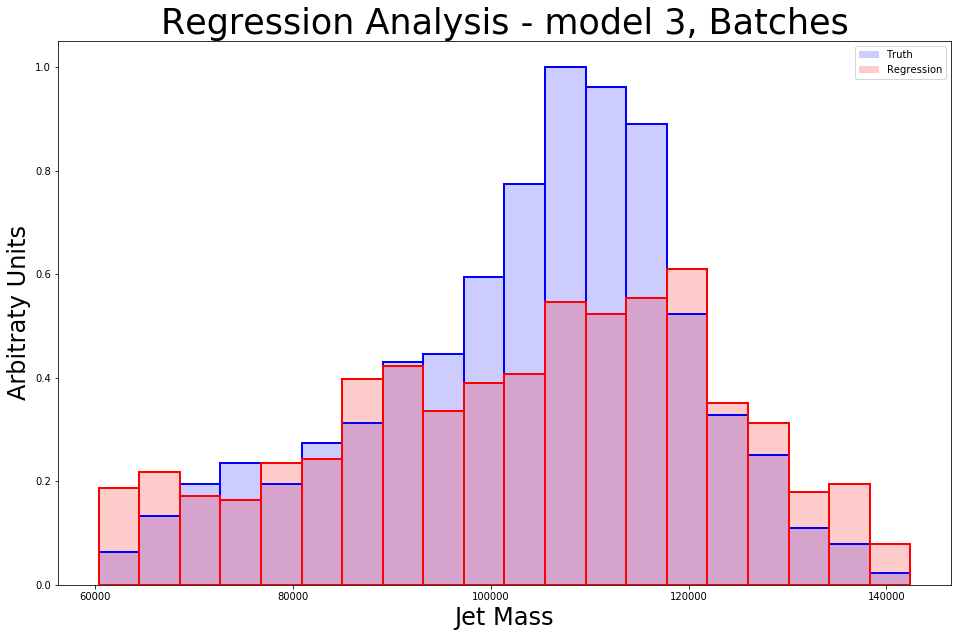

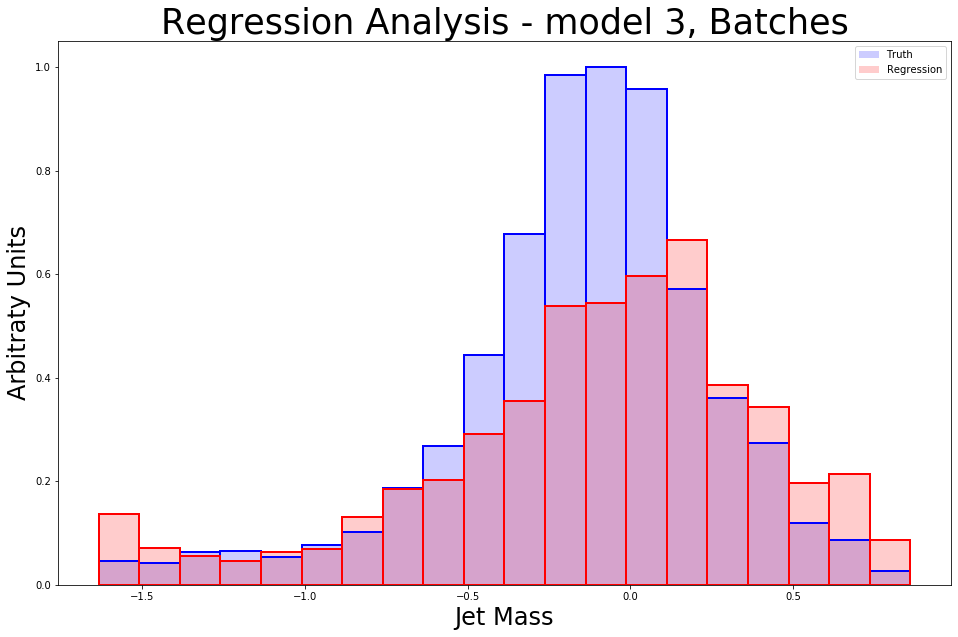

In [23]:
hist1, hist2 = correct_compare_hist(mass_transformer.inverse_transform(test_z_torch.data.numpy()),
                                    mass_transformer.inverse_transform(data_z_torch[1000:2000].data.numpy()),
                                    1.0)
hist1, hist2 = correct_compare_hist(test_z_torch.data.numpy(),
                                    data_z_torch[1000:2000].data.numpy(),
                                    ratio)

Quick Kolmogorov–Smirnov test

In [24]:
ks_2samp(hist1, hist2)

Ks_2sampResult(statistic=0.2, pvalue=0.8319696107963263)